## Weddell Sea surface freshwater budget

In [1]:
import xarray as xr
import numpy as np
import gsw
import cmocean
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import closest_point

In [213]:
month=2
print(f'{month:02}')

02


In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mesh= f'{base_dir}bathymetry/mesh_mask-20240305.nc'
run_dir  = f'{base_dir}output/ERA5_test7/'

In [3]:
gridT_files = np.sort(glob.glob(f'{run_dir}files/*grid_T*'))
SBC_files   = np.sort(glob.glob(f'{run_dir}files/*SBC*'))
ice_files   = np.sort(glob.glob(f'{run_dir}files/*icemod*'))

ds_mesh = xr.open_dataset(nemo_mesh).squeeze()
# ds_gridT= xr.open_dataset(gridT_files[0])
# ds_SBC  = xr.open_dataset(SBC_files[0]).rename({'x_grid_T':'x','y_grid_T':'y'})
# ds_ice  = xr.open_dataset(ice_files[0])

In [4]:
# regions:
weddell_overall    = {'x': slice(850, 1200, None), 'y': slice(50, -1, None)}
weddell_shelfbreak = {'x': slice(910, 1190, None), 'y': slice(210, -95, None)}

In [5]:
# ds_SBC  = xr.open_mfdataset(np.append(SBC_files[0:19], SBC_files[20:])).rename({'x_grid_T':'x','y_grid_T':'y'})
ds_T    = xr.open_mfdataset(gridT_files[0:-2]).rename({'x_grid_T':'x','y_grid_T':'y'})

In [12]:
a = ds_T.isel(x=0)

In [14]:
a['x']=0.5

In [13]:
def get_slope_contour(bathy, X, Y, pathno, level=1000):
    # From Michael Haigh
    cs = plt.contour(X, Y, bathy, levels=[level])
    x = cs.collections[0].get_paths()[pathno].vertices[:,0][::-1]
    y = cs.collections[0].get_paths()[pathno].vertices[:,1][::-1]
    plt.clf()

    return x, y

In [14]:
slope_x, slope_y = get_slope_contour(ds_mesh.isel(**weddell_shelfbreak).bathy_metry, 
                                     ds_mesh.isel(**weddell_shelfbreak).nav_lon, ds_mesh.isel(**weddell_shelfbreak).nav_lat, 0, level=1500)

shelfbreak_x = np.array([]).astype(int); shelfbreak_y = np.array([]).astype(int);
for ptx, pty in zip(slope_x, slope_y):
    [y, x] = closest_point(ds_mesh, (ptx, pty))
    shelfbreak_x = np.append(x, shelfbreak_x)
    shelfbreak_y = np.append(y, shelfbreak_y)

<Figure size 432x288 with 0 Axes>

In [19]:
ds_T_shelfbreak = ds_T.isel(x=xr.DataArray(shelfbreak_x, dims='sh'), y=xr.DataArray(shelfbreak_y, dims='sh'))#.isel(time_counter=0)

(100.0, 400.0)

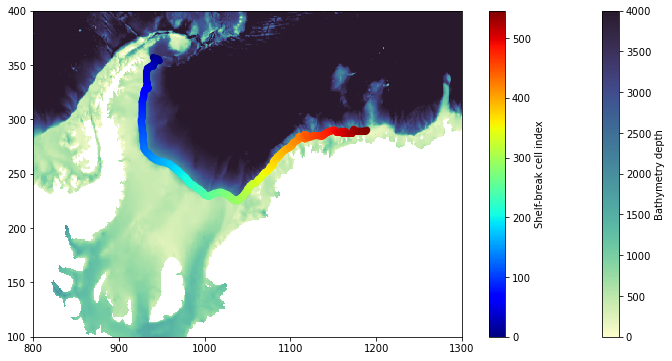

In [219]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
cm1 = ax.pcolormesh(ds_mesh.x, ds_mesh.y, ds_mesh.bathy_metry.where(ds_mesh.bathy_metry!=0), vmin=0, vmax=4000, cmap=cmocean.cm.deep)
cm2 = ax.scatter(shelfbreak_x, shelfbreak_y, c=ds_T_shelfbreak.sh, cmap='jet')
fig.colorbar(cm1, label='Bathymetry depth')
fig.colorbar(cm2, label='Shelf-break cell index')
ax.set_xlim(800, 1300)
ax.set_ylim(100, 400)

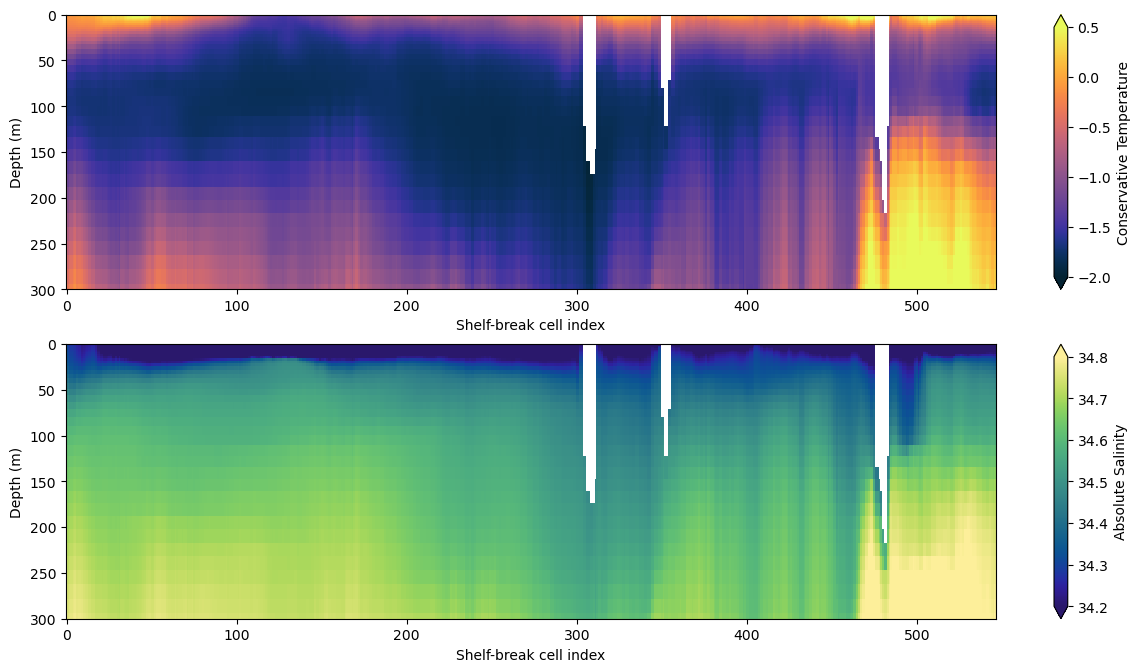

In [220]:
fig, ax = plt.subplots(2,1, figsize=(15,8), dpi=100)
cmT = ax[0].pcolormesh(ds_T_shelfbreak.sh, ds_T_shelfbreak.deptht, ds_T_shelfbreak.thetao.where(ds_T_shelfbreak.thetao!=0), 
                       vmin=-2, vmax=0.5, cmap=cmocean.cm.thermal)
cmS = ax[1].pcolormesh(ds_T_shelfbreak.sh, ds_T_shelfbreak.deptht, ds_T_shelfbreak.so.where(ds_T_shelfbreak.so!=0),
                       vmin=34.2, vmax=34.8, cmap=cmocean.cm.haline)

for axis in ax.ravel():
    axis.set_ylim(300,0)
    axis.set_ylabel('Depth (m)')
    axis.set_xlabel('Shelf-break cell index')

fig.colorbar(cmT, ax=ax[0], label='Conservative Temperature', extend='both')
fig.colorbar(cmS, ax=ax[1], label='Absolute Salinity', extend='both')

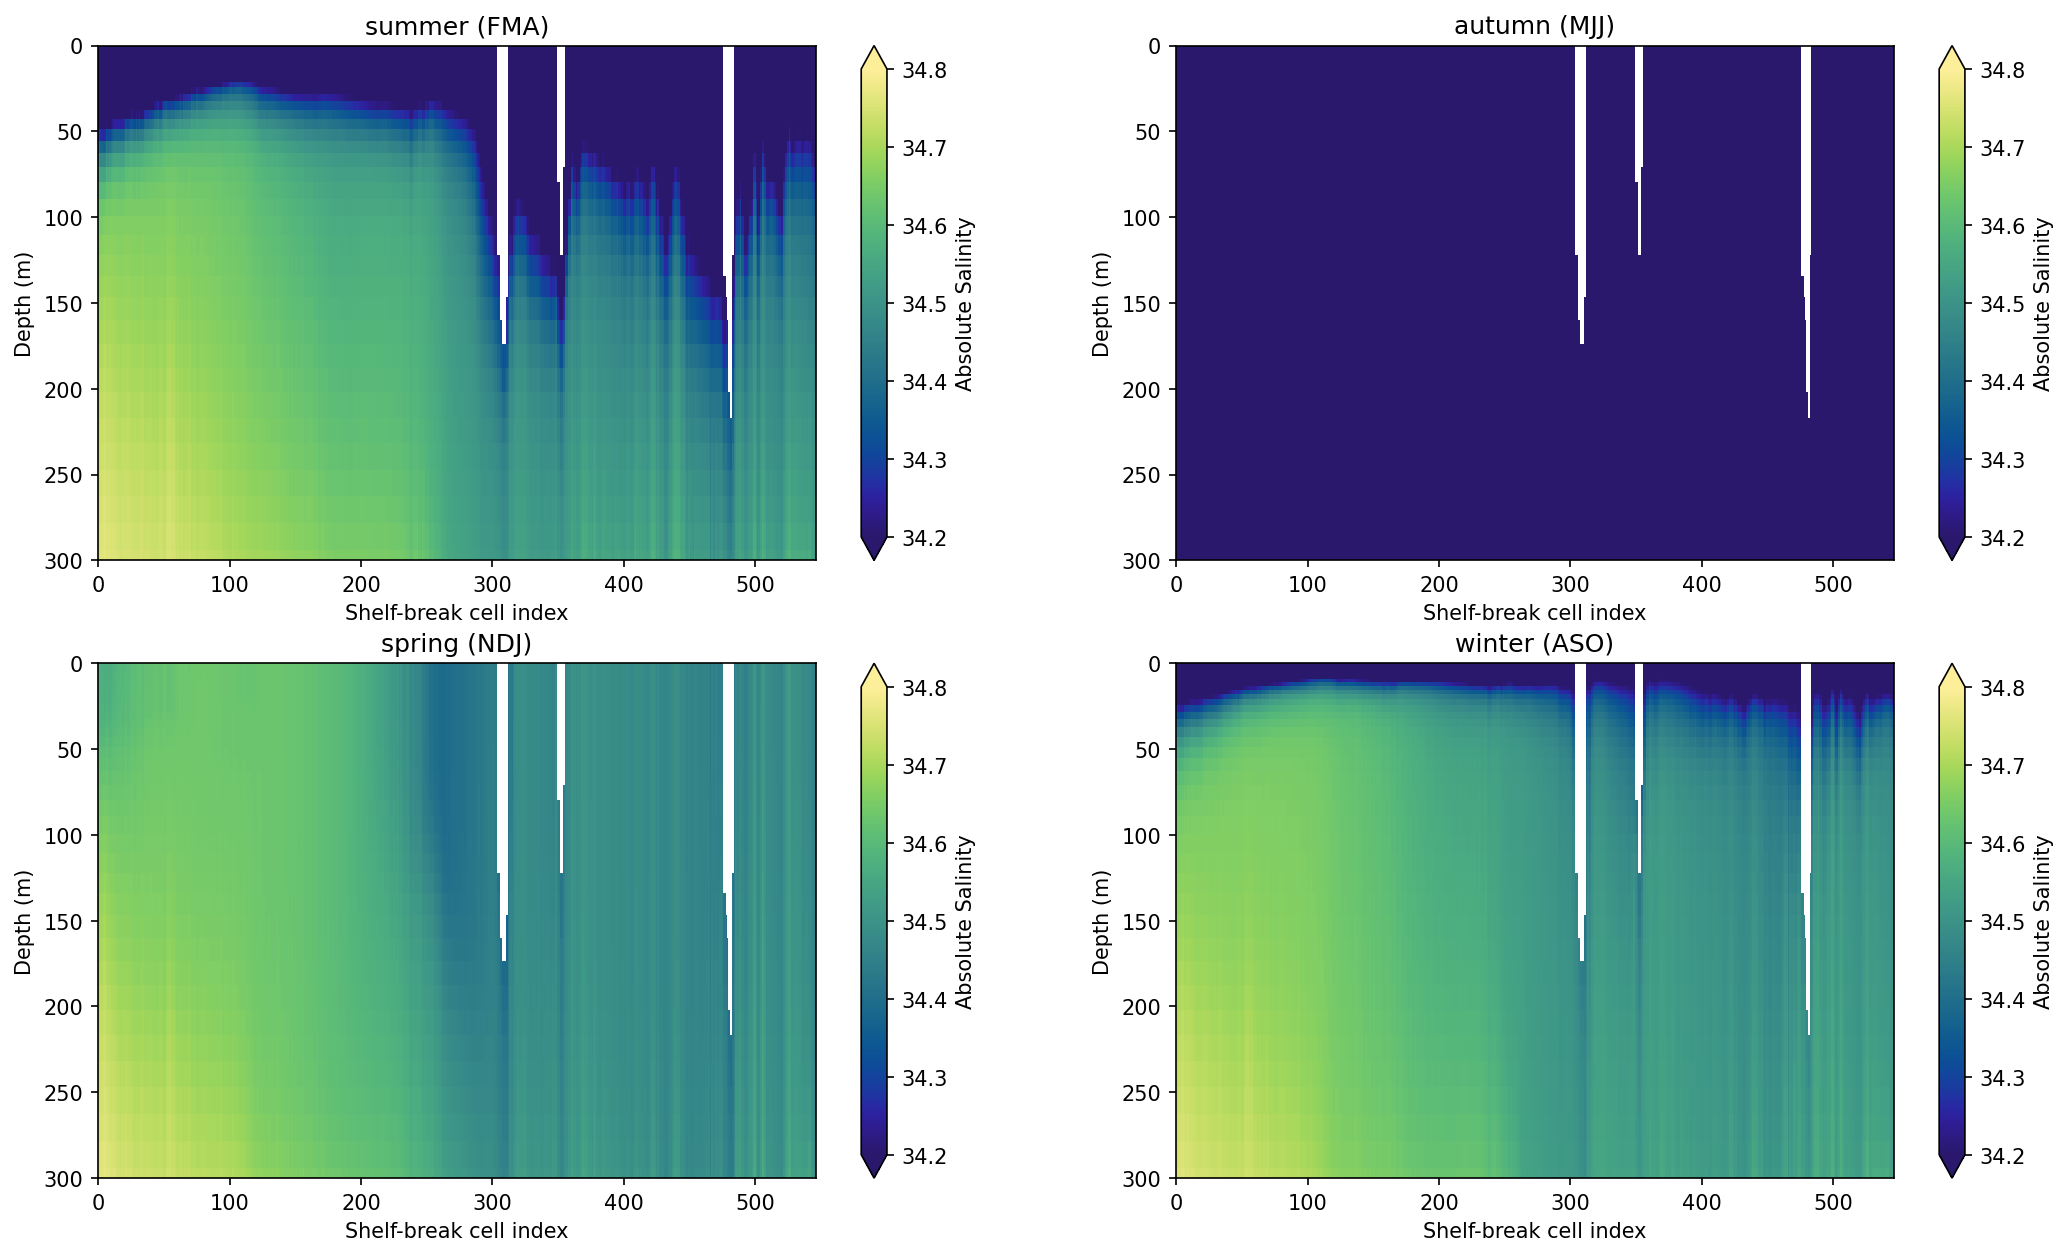

In [20]:
fig, ax = plt.subplots(2,2, figsize=(17,10), dpi=150)

season_months = [[2,3,4], [5,6,7], [8,9,10], [11,12,1]]
season_names  = ['summer (FMA)', 'autumn (MJJ)', 'spring (NDJ)', 'winter (ASO)']

for a, axis in enumerate(ax.ravel()):
    dsT_season = ds_T_shelfbreak.isel(time_counter=ds_T_shelfbreak.time_counter.dt.month.isin(season_months[a])).mean(dim='time_counter', keep_attrs=True)
    axis.set_title(season_names[a])

    cmT = axis.pcolormesh(dsT_season.sh, dsT_season.deptht, dsT_season.so.where(dsT_season.so!=0), 
                       vmin=34.2, vmax=34.8, cmap=cmocean.cm.haline)

    axis.set_ylim(300,0)
    axis.set_ylabel('Depth (m)')
    axis.set_xlabel('Shelf-break cell index')

    fig.colorbar(cmT, ax=axis, label='Absolute Salinity', extend='both')

# Streamfunction within the cavity

Look at barotropic stream function within the FRIS cavity to see whether outflow is in the right location

In [15]:
from nemo_python_git.diagnostics import barotropic_streamfunction

In [16]:
from nemo_python_git.utils import rotate_vector
from nemo_python_git.interpolation import interp_grid

In [100]:
gridU_files = np.sort(glob.glob(f'{run_dir}files/*grid_U*'))
gridV_files = np.sort(glob.glob(f'{run_dir}files/*grid_V*'))

dsU = xr.open_dataset(gridU_files[0]).isel(time_counter=0)#.isel(x=slice(800,1200)).mean(dim='time_counter')
dsV = xr.open_dataset(gridV_files[0]).isel(time_counter=0)#.isel(x=slice(800,1200)).mean(dim='time_counter')
ds_mesh_sub = ds_mesh #.isel(x=slice(800,1200))

In [204]:
# Calculate the barotropic streamfunction. 
def barotropic_streamfunction (ds_u, ds_v, ds_domcfg, periodic=True, halo=True):

    # Definite integral over depth (thkcello is dz)
    udz = (ds_u['uo']*ds_u['thkcello']).sum(dim='depthu')
    vdz = (ds_v['vo']*ds_v['thkcello']).sum(dim='depthv')
    # Interpolate to t-grid
    udz_t = interp_grid(udz, 'u', 't', periodic=periodic, halo=halo)
    vdz_t = interp_grid(vdz, 'v', 't', periodic=periodic, halo=halo)
    tmask_full = (ds_domcfg['tmask']).sum(dim='nav_lev')
    udz_t = xr.where(tmask_full.values==0, np.nan, udz_t)
    vdz_t = xr.where(tmask_full.values==0, np.nan, vdz_t)
    # Rotate to get geographic velocity components, and save cos and sin of angles
    udz_tg, vdz_tg, cos_grid, sin_grid = rotate_vector(udz_t, vdz_t, ds_domcfg, gtype='T', periodic=periodic, halo=halo, return_angles=True)
    # Get integrand: dy in north-south direction, based on angle of grid
    dy = ds_domcfg['e2t']*cos_grid
    # Indefinite integral from south to north, and convert to Sv
    return udz, vdz, udz_t, vdz_t, udz_tg, vdz_tg, dy, cos_grid, sin_grid #.cumsum(dim='y')*1e-6

In [205]:
udz, vdz, udz_t, vdz_t, udz_tg, vdz_tg, dy, cos_grid, sin_grid = barotropic_streamfunction(dsU.rename({'e3u':'thkcello'}), dsV.rename({'e3v':'thkcello'}), ds_mesh_sub)

In [23]:
#udz_t * dy cumsum looks normal,
#vdz_t * dy cumsum doesn't

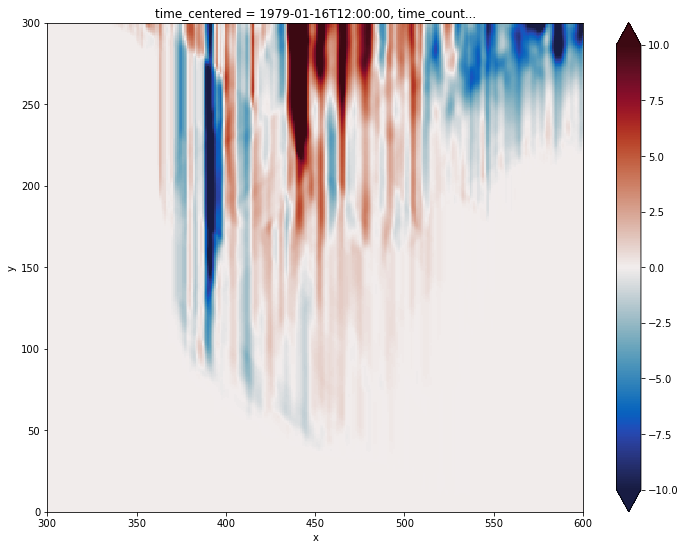

In [211]:
kwags = {'figsize':(12,9), 'vmin':-10, 'vmax':10, 'cmap':cmocean.cm.balance, 'xlim':(300,600), 'ylim':(0,300)}
((vdz_tg*dy).cumsum(dim='y')*1e-6).plot(**kwags)

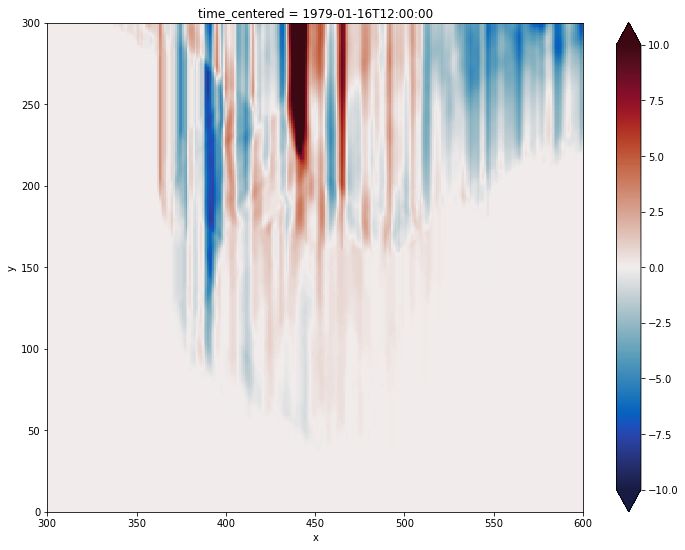

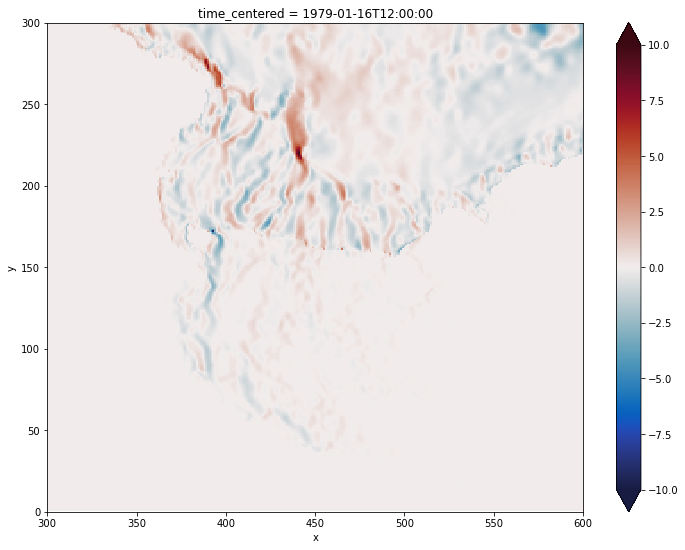

In [206]:
kwags = {'figsize':(12,9), 'vmin':-10, 'vmax':10, 'cmap':cmocean.cm.balance, 'xlim':(300,600), 'ylim':(0,300)}
((dsV['vo']*1e-5).sum('depthv')*dy).cumsum('y').plot(**kwags)
(dsV['vo'].sum('depthv')*dy*1e-4).plot(**kwags)

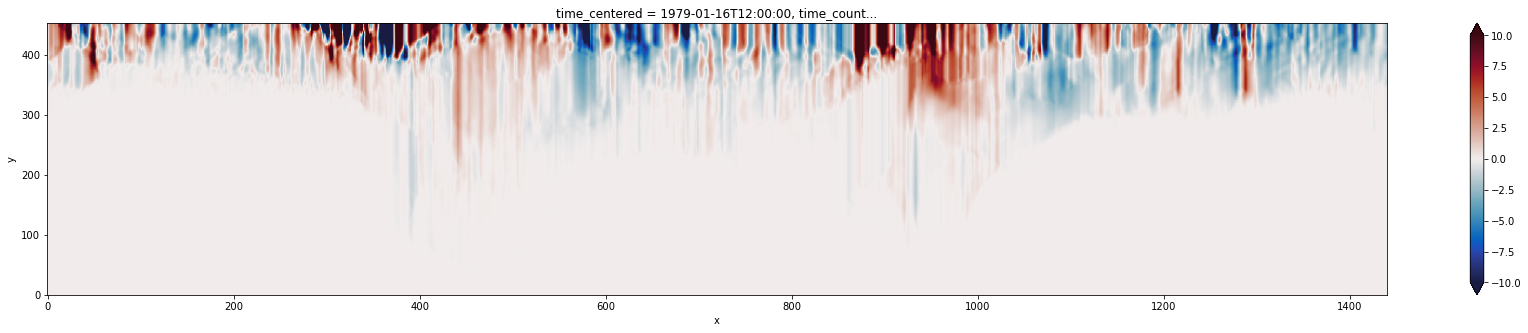

In [212]:
(vdz_tg*dy*1e-7).cumsum(dim='y').plot(figsize=(30,5), vmin=-10, vmax=10, cmap=cmocean.cm.balance)
# ds_mesh.isfdraft.plot(figsize=(12,6), vmin=-1, vmax=1, cmap=cmocean.cm.balance)
# vdz, udz_t, vdz_t, udz_tg, vdz_tg, dy

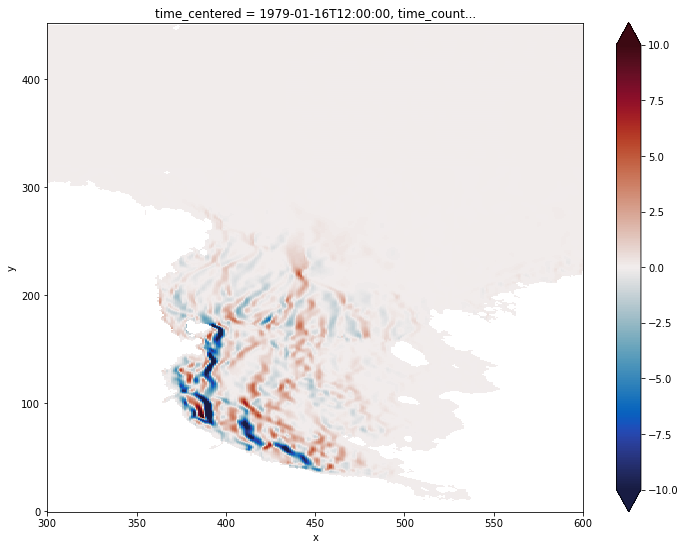

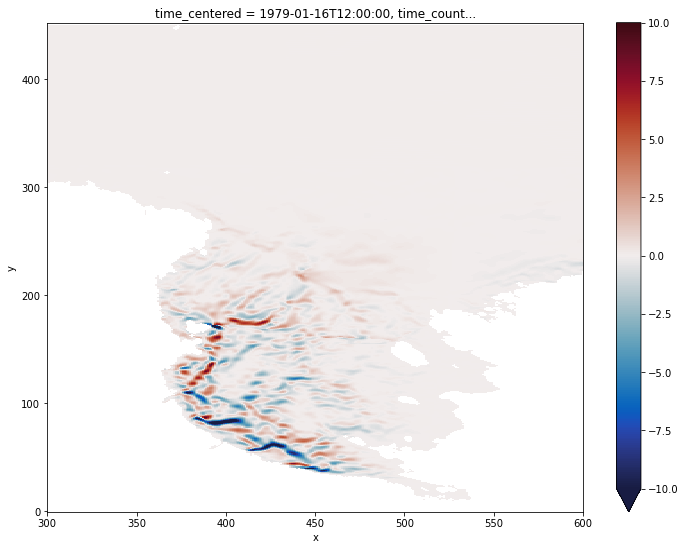

In [208]:
(udz_tg - udz_t).plot(figsize=(12,9), vmin=-10, vmax=10, cmap=cmocean.cm.balance, xlim=(300, 600))
(vdz_tg - vdz_t).plot(figsize=(12,9), vmin=-10, vmax=10, cmap=cmocean.cm.balance, xlim=(300, 600))
# vdz, udz_t, vdz_t, udz_tg, vdz_tg, dy

In [32]:
# # I think it is probably filling the land values with the last cumulative sum value and then continuing on cumulating
# for row in range(btsf['x'].size):
#     btsf_row = (btsf.isel(x=row).dropna(dim='y')*1e-6).cumsum(dim='y')
#     btsf_full_row = xr.where(np.isnan(btsf.isel(x=row)), btsf_row, np.nan)
    

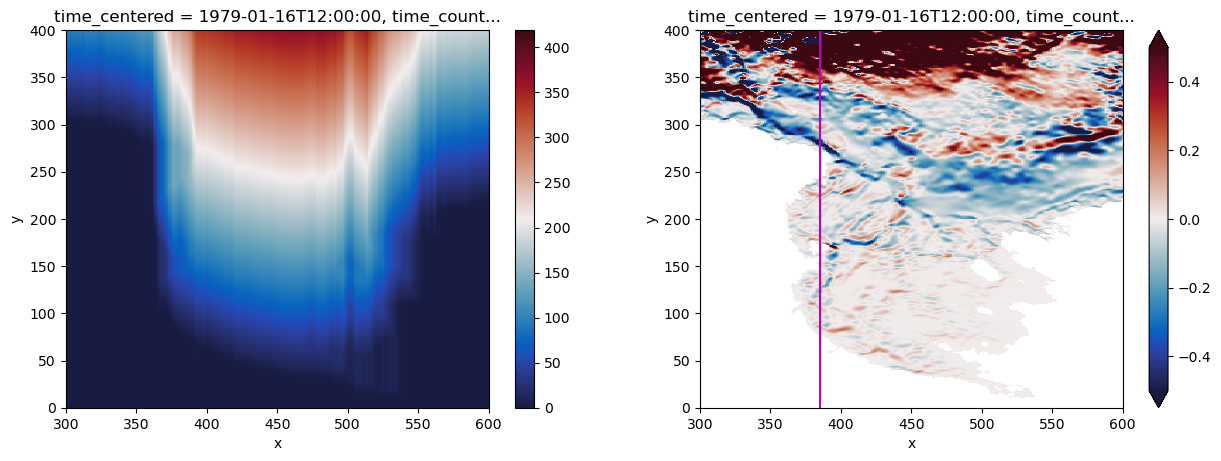

In [72]:
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=100)
xr.where(np.isnan(btsf), 0, 1).cumsum(dim='y', skipna=True).plot(ax=ax[0], vmin=None, vmax=None, 
                                                          cmap=cmocean.cm.balance, xlim=(300,600), ylim=(0,400))
(btsf*1e-6).plot(ax=ax[1], vmin=-0.5, vmax=0.5, cmap=cmocean.cm.balance, xlim=(300,600), ylim=(0,400))
ax[1].plot([385,385], [0, 400], '-m')

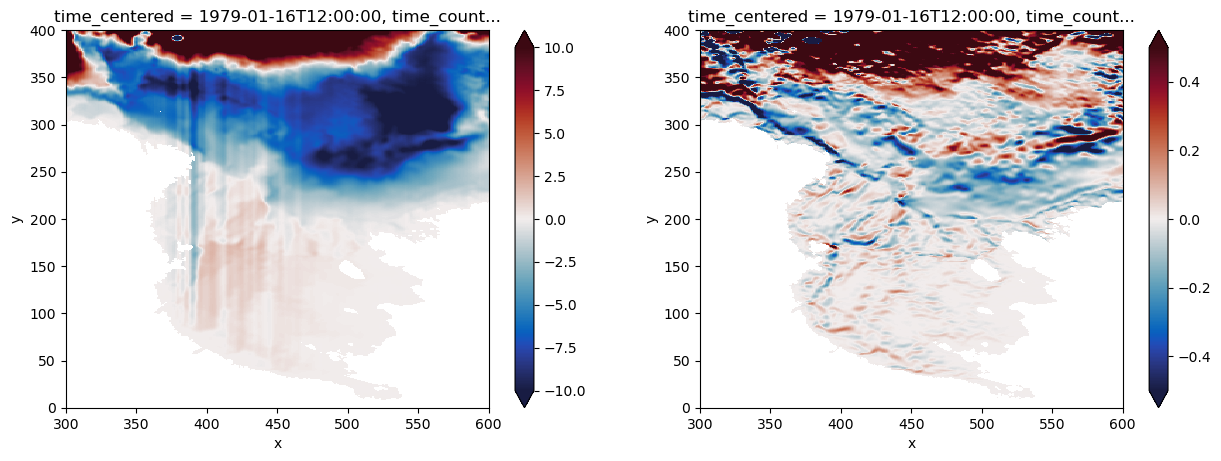

In [209]:
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=100)
(btsf*1e-6).cumsum(dim='y', skipna=True).where(ds_mesh.misf!=0).plot(ax=ax[0], vmin=-10, vmax=10, 
                                                                     cmap=cmocean.cm.balance, xlim=(300,600), ylim=(0,400))
(btsf*1e-6).plot(ax=ax[1], vmin=-0.5, vmax=0.5, cmap=cmocean.cm.balance, xlim=(300,600), ylim=(0,400))

In [58]:
basin_mask = ~np.isnan(btsf)

sum_data = (btsf*1e-6).cumsum(dim='y', keep_attrs=True, skipna=True)    
sum_data = sum_data.where(basin_mask)

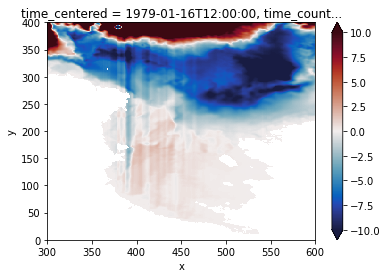

In [59]:
(sum_data).plot(vmin=-10, vmax=10, cmap=cmocean.cm.balance, xlim=(300,600), ylim=(0,400))

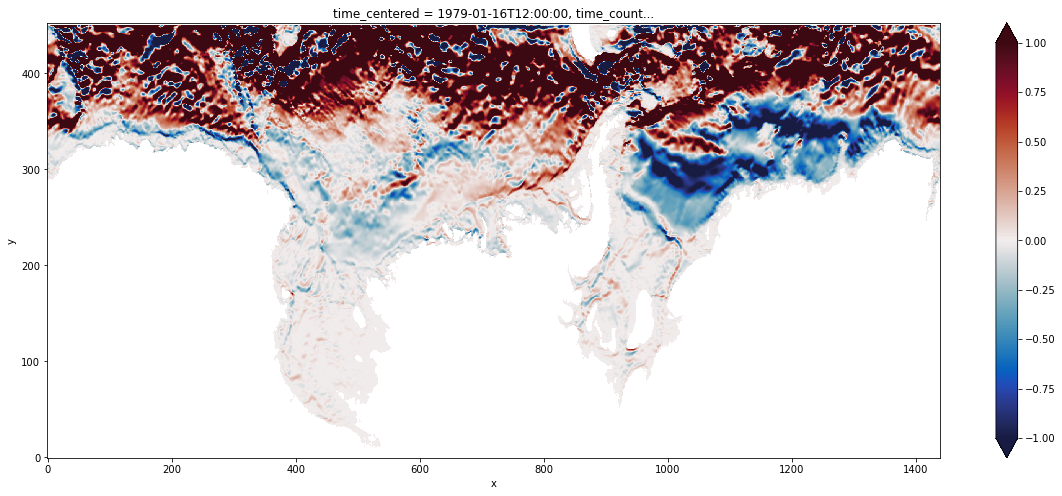

In [109]:
(btsf*1e-6).plot(figsize=(20,8), vmin=-1, vmax=1, cmap=cmocean.cm.balance)

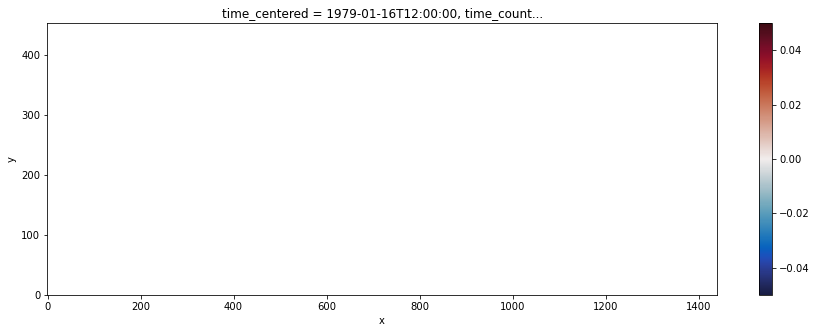

In [70]:
btsf.plot(figsize=(15,5), vmin=-50, vmax=50, cmap=cmocean.cm.balance)

In [44]:
btsf_all = btsf.where(ds_mesh_sub.misf != 0).isel(y=slice(50,325), x=slice(50,275))
btsf_ice = btsf.where(ds_mesh_sub.isfdraft != 0).isel(y=slice(50,325), x=slice(50,275))
ds_sub   = ds_mesh_sub.isel(y=slice(50,325), x=slice(50,275))

/tmp/ipykernel_2552/2731817782.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(ds_sub.nav_lon, ds_sub.nav_lat, btsf_all, vmin=-5, vmax=5, cmap=cmocean.cm.balance)
/tmp/ipykernel_2552/2731817782.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(ds_sub.nav_lon, ds_sub.nav_lat, btsf_ice, vmin=-5, vmax=5, cmap=cmocean.cm.balance)


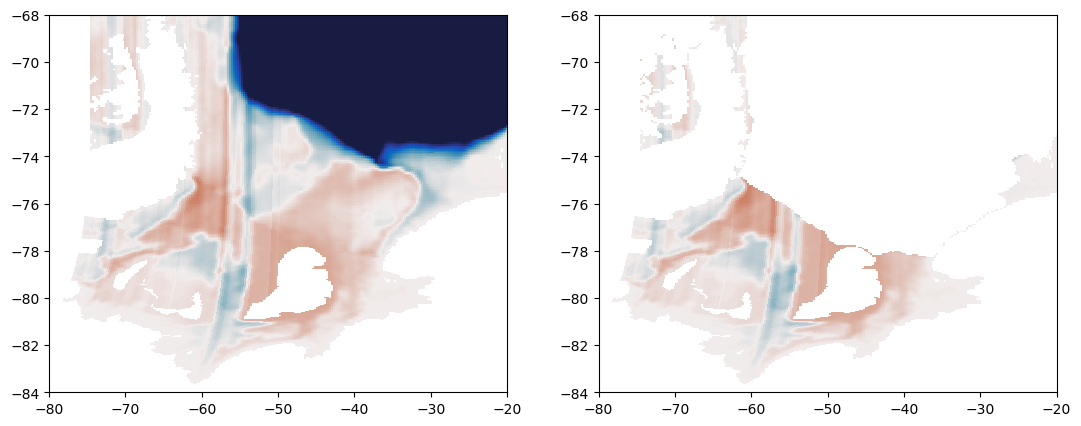

In [49]:
fig, ax = plt.subplots(1,2, figsize=(13,5), dpi=100)
ax[0].pcolormesh(ds_sub.nav_lon, ds_sub.nav_lat, btsf_all, vmin=-5, vmax=5, cmap=cmocean.cm.balance)
ax[1].pcolormesh(ds_sub.nav_lon, ds_sub.nav_lat, btsf_ice, vmin=-5, vmax=5, cmap=cmocean.cm.balance)
for axis in ax.ravel():
    axis.set_xlim(-80,-20)
    axis.set_ylim(-84,-68)
# btsf_all.plot(ax=ax[0], vmin=-5, vmax=5, cmap=cmocean.cm.balance)
# btsf_ice.plot(ax=ax[1], vmin=-5, vmax=5, cmap=cmocean.cm.balance)
# btsf.isel(time_counter=0, x=slice(850,1050), y=slice(50,300)).plot(figsize=(12,8), vmin=-10, vmax=10, cmap=cmocean.cm.balance)

In [ ]:
btsf.isel(time_counter=0).plot(figsize=(12,8), vmin=-10, vmax=10, cmap=cmocean.cm.balance)